#  NIFTI_NORDIC in Nipype

__Author:__ Moni Dörig

### References:

__NORDIC:__
- Vizioli, L., Moeller, S., Dowdle, L. et al. Lowering the thermal noise barrier in functional brain mapping with magnetic resonance imaging. Nat Commun 12, 5181 (2021). https://doi.org/10.1038/s41467-021-25431-8
- [Code on GitHub supporting the publication](https://github.com/SteenMoeller/NORDIC_Raw)

__Opensource Data from OpenNeuro:__
- Javier Gonzalez-Castilloa and Colin W. Hoy and Daniel A. Handwerker and Vinai Roopchansingh and Souheil J. Inati and Ziad S. Saad and Robert W. Cox and Peter A. Bandettini (2023). Large Single-Subject Functional MRI Datasets at 7T. OpenNeuro. [Dataset] doi: [10.18112/openneuro.ds001555.v1.0.1](https://openneuro.org/datasets/ds001555/versions/1.0.1)

In [1]:
import lmod
await lmod.purge(force=True)
await lmod.load('matlab/2022a')
await lmod.load('afni/23.3.02')
await lmod.load('fsl/6.0.7.4')
await lmod.list()

['matlab/2022a', 'afni/23.3.02', 'fsl/6.0.7.4']

In [2]:
from nipype import Node, Function, Workflow
from nipype.interfaces import afni
from nipype.interfaces.fsl import BET, ApplyMask
from nipype.interfaces.io import DataSink, SelectFiles, File
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.base import (CommandLine, traits, TraitedSpec,
                                    BaseInterface, BaseInterfaceInputSpec, File)
from nipype.algorithms.confounds import TSNR
from scipy.io import savemat
import os
import sys

### Download data from OpenNeuro

In [3]:
%%capture
# Download 1 subject, don't display output
PATTERN = "sub-001/ses-01"

!datalad install https://github.com/OpenNeuroDatasets/ds001555.git
!cd ds001555 && datalad get $PATTERN

In [4]:
!cd ds001555/sub-001/ses-01 && tree -L 4

.
├── anat
│   ├── sub-001_ses-01_acq-MPRAGE_run-001_T1w.json
│   ├── sub-001_ses-01_acq-MPRAGE_run-001_T1w.nii.gz -> ../../../.git/annex/objects/FG/jG/MD5E-s11361709--21046e99e714dbe42ab2fafbea250db8.nii.gz/MD5E-s11361709--21046e99e714dbe42ab2fafbea250db8.nii.gz
│   ├── sub-001_ses-01_run-001_PD.json
│   └── sub-001_ses-01_run-001_PD.nii.gz -> ../../../.git/annex/objects/z7/Pp/MD5E-s11969134--76c8adafe414fdd1a0be886cb6917e6b.nii.gz/MD5E-s11969134--76c8adafe414fdd1a0be886cb6917e6b.nii.gz
├── func
│   ├── sub-001_ses-01_task-HalfFovNoTask_run-003_bold.json
│   ├── sub-001_ses-01_task-HalfFovNoTask_run-003_bold.nii.gz -> ../../../.git/annex/objects/Mm/44/MD5E-s117000078--ec792152dff29c551f1f567c7e0fba34.nii.gz/MD5E-s117000078--ec792152dff29c551f1f567c7e0fba34.nii.gz
│   ├── sub-001_ses-01_task-HalfFovNoTask_run-004_bold.json
│   ├── sub-001_ses-01_task-HalfFovNoTask_run-004_bold.nii.gz -> ../../../.git/annex/objects/G3/GK/MD5E-s117070442--ba4595bcc7e8f34a169f171a4e33a5d7.nii.gz/MD5E-s117

In [5]:
#define directory with data
data_dir = os.path.abspath(os.path.join('.', 'ds001555'))

### Nipype Interface for NIFTI_NORDIC Matlab Script

In [6]:
# Add the scripts directory to sys.path (NIFIT_NORDIC_nipype.m and NIFTI_NORDIC_NIPYPE.py)
scripts_dir = os.path.abspath(os.path.join('.', 'interfaces'))

if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

In [7]:
#import NiftiNordic class to wrap matlab script
from NIFTI_NORDIC_interface_default import NiftiNordic

In [8]:
NiftiNordic.help()

Inputs::

        [Mandatory]
        additional_path: (a string)
                Additional path to be added with addpath in MATLAB
        fn_magn_in: (a string or os.PathLike object referring to an existing
                  file)
                Input magnitude file
        fn_phase_in: (a string or os.PathLike object referring to an existing
                  file)
                Input phase file
        fn_out: (a string)
                Output prefix or suffix

Outputs::

        output_file: (a pathlike object or string representing an existing
                  file or None)
                Denoised nii file
        add_info_file: (a pathlike object or string representing an existing
                  file or None)
                Optional output file for additional info
        complex_phase_file: (a pathlike object or string representing an
                  existing file or None)
                Optional output file - saves phase in similar format as input phase
        co

### Initialize workflow and get funcitonal and anatomical data

In [9]:
# Create a workflow
#where to store workflow/working directories
experiment_dir = os.path.abspath(os.path.join('.', 'NORDIC_output'))

workflow = Workflow(name='workflow_nordic', base_dir=experiment_dir)
workflow.config["execution"]["crashfile_format"] = "txt"

#functional and anatomical data
fn_magn_in = os.path.join(data_dir, 'sub-001/ses-01/func/sub-001_ses-01_task-HalfFovNoTask_run-003_bold.nii.gz')
anat = os.path.join(data_dir, 'sub-001/ses-01/anat/sub-001_ses-01_acq-MPRAGE_run-001_T1w.nii.gz')

### Get mask of anatomical image 

In [10]:
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"

In [11]:
bet = Node(BET(), name='bet')
bet.inputs.in_file = anat 
bet.inputs.mask = True  
bet.inputs.frac = 0.65
bet.inputs.output_type = 'NIFTI_GZ'

### Motion correction of raw data

In [12]:
volreg_raw = Node(afni.Volreg(interp='Fourier', outputtype = 'NIFTI_GZ'), 
                 name='volreg_raw')

volreg_raw.inputs.in_file = fn_magn_in

### Resample anatomical mask to functional image

In [13]:
#resample anat mask to func dimension and resolution
def resample_mask(in_file, wb_mask):
    
    #get binary masks of functional run
    import os
    import nibabel as nib
    from nilearn.image import resample_to_img

    base_name = os.path.basename(in_file) 
    file_without_ext = base_name.rsplit('.', 2)[0] #split nii.gz
    new_file = file_without_ext + '_func_mask.nii.gz'
    file_path = os.path.join(os.getcwd(), new_file)

    mask_img = resample_to_img(source_img=nib.load(wb_mask), target_img=nib.load(in_file), interpolation='nearest')
    nib.save(mask_img, file_path)

    return file_path


get_fmri_mask = Node(Function(input_names=['in_file', 'wb_mask'], #func run, wb mask of bet
                        output_names=['mask_file'],
                        function=resample_mask),
                        name='resample_mask')

workflow.connect(bet, 'mask_file', get_fmri_mask, 'wb_mask')
workflow.connect(volreg_raw, 'out_file', get_fmri_mask, 'in_file')

### Define input arguments for NORDIC 
- not mandatory, otherwise default values will be initialized for ARG in NIFTI_NORDIC_nipype.m

In [ ]:
arg_struct = {
    'noise_volume_last': 0,             # specifies volume from the end of the series, default = 0
    'factor_error': 1,                  # >1 use higher noisefloor, <1 use lower noisefloor, default = 1
    'full_dynamic_range': 0,            # 0 keep input scale, output maximises range, default = 0
    'temporal_phase': 1,                # calculate and apply spatial filter to each time-point - better in case of phase-drifts etc., default = 3
    'phase_filter_width': 3,            # specifies the width of the smoothing filter for the phase, default = 3
    'noise_volume_last': 0,             # specifiec volume from the end of the series, default = 0
    'gfactor_patch_overlap' : 6,        # overlap for the patch within which local PCA is ran
    'kernel_size' : [14,14,1],          # also [28, 28, 1]
    'magnitude_only': 1,                # Using complex or magnitude only. Default is []. Function still needs two inputs but will ignore the second
    'save_gfactor_map': 1,              # 1 saves the realtive gfactor, 2 saves the gfactor and does not complete the NORDIC processing
    'save_add_info': 1,                 # save additional information, including the number of components removed
    'save_residual_matlab': 1,          # saves the NORDIC residuals
}

#saves mat in the given directory
mat_file_opt = 'ARG_nordic.mat'
savemat(mat_file_opt, {'ARG': arg_struct}) #needs to be called ARG for it to work in the NIFTI_NORDIC_nipype matlab script

cwd = os.getcwd()

### Create Nipype Node with NIFTI_NORDIC Interface

In [14]:
# Define paths to files and other input arguments
fn_phase_in = fn_magn_in #we chose magnitude only; the function will still need two inputs, but will ignore the second
fn_out = '_NORDIC'
nifti_nordic_script_path = scripts_dir #path where NIFTI_NORDIC_nipype.mat is stored
#ARG = os.path.join(cwd, mat_file_opt)

# Create the node
nifti_nordic_node = Node(NiftiNordic(), name='nifti_nordic')

# Set the input values
nifti_nordic_node.inputs.fn_magn_in = fn_magn_in
nifti_nordic_node.inputs.fn_phase_in = fn_phase_in
nifti_nordic_node.inputs.fn_out = fn_out
nifti_nordic_node.inputs.additional_path = nifti_nordic_script_path #needs this to add it to the matlab paths
#nifti_nordic_node.inputs.ARG = ARG #input is not mandatory

### Motion Correciton after Nordic

In [15]:
# Motion correction AFNI 3dvolreg------------------------------------------------------------------------------
volreg_nordic = Node(afni.Volreg(interp='Fourier', outputtype = 'NIFTI_GZ'), 
                 name='volreg_nordic')

workflow.connect(nifti_nordic_node, 'output_file', volreg_nordic, 'in_file')

### Mask functional data (raw and after nordic)

In [16]:
masker_raw = Node(ApplyMask(), name='masker_raw')
workflow.connect(volreg_raw, 'out_file', masker_raw, 'in_file')
workflow.connect(get_fmri_mask, 'mask_file', masker_raw, 'mask_file')

In [17]:
masker_nordic = Node(ApplyMask(), name='masker_nordic')
workflow.connect(volreg_nordic, 'out_file', masker_nordic, 'in_file')
workflow.connect(get_fmri_mask, 'mask_file', masker_nordic, 'mask_file')

### Node to compute TSNR
Computes the time-course SNR for a time series

Typically you want to run this on a realigned time-series - in this case, it is not realigned yet.

In [18]:
tsnr_nordic = Node(TSNR(), name='compute_tsnr_nordic')
workflow.connect(masker_nordic, 'out_file', tsnr_nordic,'in_file')

In [19]:
tsnr_raw = Node(TSNR(), name='compute_tsnr_raw')
workflow.connect(masker_raw, 'out_file', tsnr_raw,'in_file')

#### Plot TSNR

In [20]:
def plot_tsnr(data_path, base_name):
    import numpy as np
    import nibabel as nib
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import os
    
    data = nib.load(data_path).get_fdata()

    x = data.shape[0] // 2
    y = data.shape[1] // 2
    z = data.shape[2] // 2

    fig, axes = plt.subplots(2, 2) #, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 0.1]})

    ax = axes[0, 0]
    im = ax.imshow(data[:, :, z], cmap=mpl.cm.hot,vmax=40)
    ax.set_title(f'Axial Slice at z={z}')

    ax = axes[0, 1]
    im = ax.imshow(np.rot90(data[:, y, :]), cmap=mpl.cm.hot,vmax=40)
    ax.set_title(f'Coronal Slice at y={y}')

    ax = axes[1, 0]
    im = ax.imshow(np.rot90(data[x, :, :]), cmap=mpl.cm.hot, vmax=40)
    ax.set_title(f'Sagittal Slice at x={x}')

    # Remove the unused subplot
    fig.delaxes(axes[1, 1])

    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [x, y, width, height]
    fig.colorbar(im, cax=cbar_ax)

    fig.set_size_inches(9, 9) #8,8
    #mean_tsnr = np.mean(data[data>0])
    global_tsnr = np.median(data[data > 0])
    

    if base_name.endswith('.gz'):
        basename = os.path.basename(base_name)[0:-7]
    elif base_name.endswith('.nii'):
        basename = os.path.basename(base_name)[0:-4]
    title = 'Global TSNR of  ' + basename + ': ' + str(int(global_tsnr))
    fig.suptitle(title, fontsize=12) 
    
    path_mapflow, _ = os.path.split(os.getcwd())
    path_node, _ = os.path.split(path_mapflow)
    
    plt.savefig(path_node +'/'+ basename) 

#tsrn of denoised data
tsnr_plot_nordic = Node(Function(input_names=['data_path', 'base_name'], 
                                function=plot_tsnr),
                                name='plot_tsnr_nordic')

workflow.connect(tsnr_nordic, 'tsnr_file', tsnr_plot_nordic, 'data_path')
workflow.connect(volreg_nordic, 'out_file', tsnr_plot_nordic, 'base_name')


#tsrn of raw data
tsnr_plot_raw = Node(Function(input_names=['data_path', 'base_name'],
                                function=plot_tsnr),
                                name='plot_tsnr_raw')

workflow.connect(tsnr_raw, 'tsnr_file', tsnr_plot_raw, 'data_path')
workflow.connect(volreg_raw, 'out_file', tsnr_plot_raw, 'base_name')

### Datasink Node

In [21]:
# Create a DataSink node to save the output to a specified location
datasink = Node(DataSink(base_directory=os.path.join(experiment_dir, 'workflow_nordic')),
               name='datasink')


# Connect desired outputs to datasink
#nordic
workflow.connect(nifti_nordic_node, 'output_file', datasink, 'nordic_output') 
workflow.connect(nifti_nordic_node, 'add_info_file', datasink, 'nordic_output.@info_file')
workflow.connect(nifti_nordic_node, 'gfactor_map_file', datasink, 'nordic_output.@gfactor')
workflow.connect(nifti_nordic_node, 'residual_mat_file', datasink, 'nordic_output.@residual')

#tsnr
workflow.connect(tsnr_nordic, 'tsnr_file', datasink, 'tsnr_output.@tsnr_nordic')
workflow.connect(tsnr_raw, 'tsnr_file', datasink, 'tsnr_output.@tsnr_raw')

240830-12:23:52,325 nipype.workflow INFO:
	 Generated workflow graph: /mnt/neurodesktop-storage/Clean_notebooks/NORDIC_output/workflow_nordic/graph.png (graph2use=colored, simple_form=True).


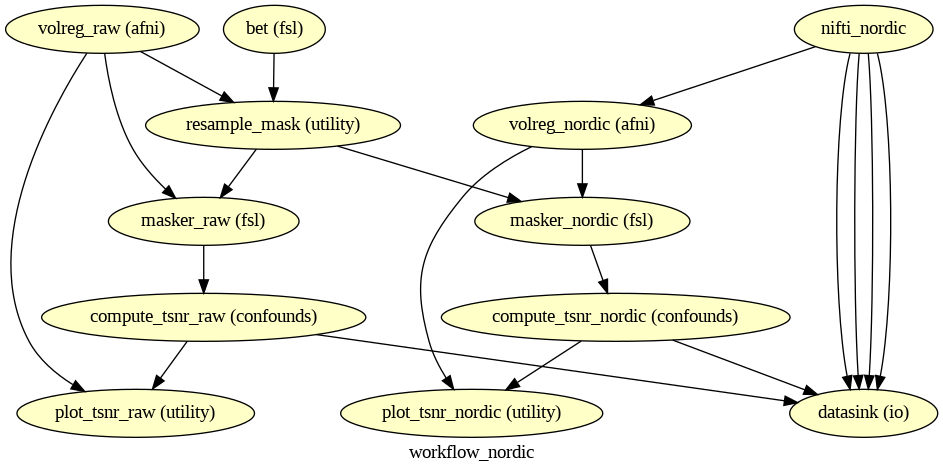

In [22]:
# Create output graph
workflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(workflow.base_dir, workflow.name, 'graph.png'))

240830-12:23:56,451 nipype.workflow INFO:
	 Generated workflow graph: /mnt/neurodesktop-storage/Clean_notebooks/NORDIC_output/workflow_nordic/graph.png (graph2use=flat, simple_form=True).


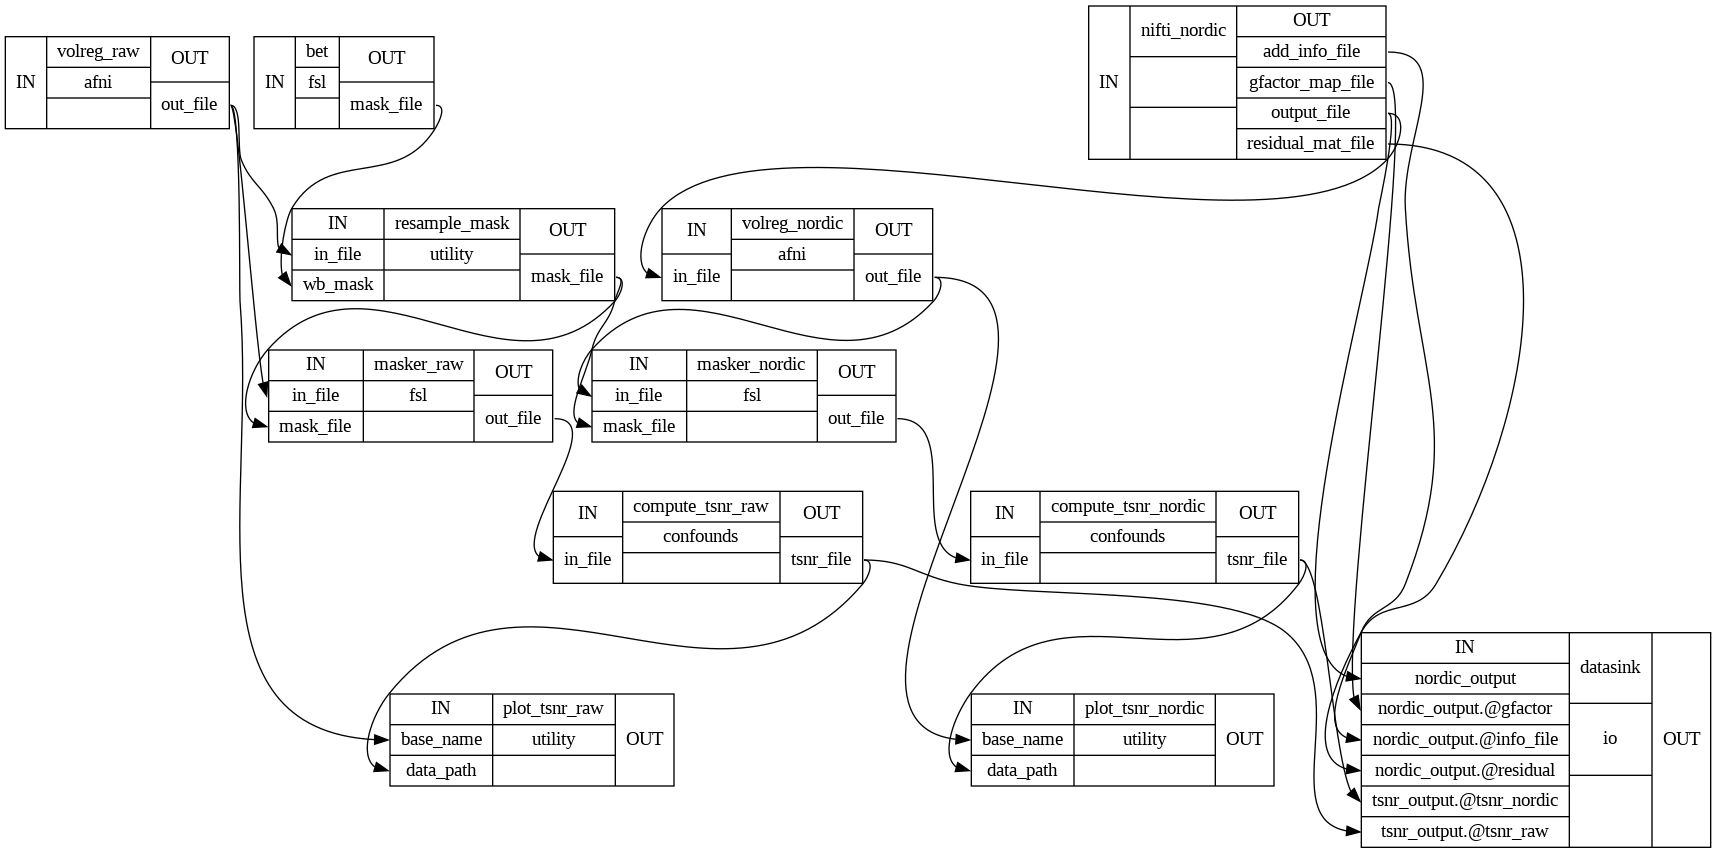

In [23]:
workflow.write_graph(graph2use='flat', format='png', simple_form=True)

Image(filename=os.path.join(workflow.base_dir, workflow.name, 'graph_detailed.png'))

In [24]:
# Run the workflow
workflow.run('MultiProc', plugin_args={'n_procs':16})

240830-12:23:56,523 nipype.workflow INFO:
	 Workflow workflow_nordic settings: ['check', 'execution', 'logging', 'monitoring']
240830-12:23:56,530 nipype.workflow INFO:
	 Running in parallel.
240830-12:23:56,533 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 219.48/219.48, Free processors: 16/16.
240830-12:23:56,592 nipype.workflow INFO:
	 [Job 0] Cached (workflow_nordic.bet).
240830-12:23:56,594 nipype.workflow INFO:
	 [Job 1] Cached (workflow_nordic.volreg_raw).
240830-12:23:56,697 nipype.workflow INFO:
	 [Node] Setting-up "workflow_nordic.nifti_nordic" in "/mnt/neurodesktop-storage/Clean_notebooks/NORDIC_output/workflow_nordic/nifti_nordic".
240830-12:23:56,706 nipype.workflow INFO:
	 [Node] Executing "nifti_nordic" <NIFTI_NORDIC_interface_default.NiftiNordic>
240830-12:23:56,815 nipype.interface INFO:
	 stdout 2024-08-30T12:23:56.815783:MLM_LICENSE_FILE=/home/jovyan/Downloads
240830-12:23:57,447 nipype.interface INFO:
	 stdout 2024-08-30T12

### Check output

In [25]:
!cd NORDIC_output && tree -L 4

.
├── sub-001_ses-01_task-HalfFovNoTask_run-003_bold_NORDIC_volreg.png
├── sub-001_ses-01_task-HalfFovNoTask_run-003_bold_volreg.png
└── workflow_nordic
    ├── bet
    │   ├── _0x47b34e7fc549b5e85aadbc455931da5c.json
    │   ├── _inputs.pklz
    │   ├── _node.pklz
    │   ├── _report
    │   │   └── report.rst
    │   ├── command.txt
    │   ├── result_bet.pklz
    │   └── sub-001_ses-01_acq-MPRAGE_run-001_T1w_brain_mask.nii.gz
    ├── compute_tsnr_nordic
    │   ├── _0x60d619be6978d68f8536c766ac16ea63.json
    │   ├── _inputs.pklz
    │   ├── _node.pklz
    │   ├── _report
    │   │   └── report.rst
    │   ├── result_compute_tsnr_nordic.pklz
    │   └── tsnr.nii.gz
    ├── compute_tsnr_raw
    │   ├── _0x047af29184614900805e81efbd1e6f03.json
    │   ├── _inputs.pklz
    │   ├── _node.pklz
    │   ├── _report
    │   │   └── report.rst
    │   ├── result_compute_tsnr_raw.pklz
    │   └── tsnr.nii.gz
    ├── d3.js
    ├── datasink
    │   ├── _0x4aa87808415387063234b6bdc4295c09.json
 

### Plot TSNR maps and the global TSNR (median) to check the effect of NORDIC

In [26]:
tsnr_img_nordic = os.path.join(experiment_dir, 'sub-001_ses-01_task-HalfFovNoTask_run-003_bold_NORDIC_volreg.png')
tsnr_img_raw = os.path.join(experiment_dir, 'sub-001_ses-01_task-HalfFovNoTask_run-003_bold_volreg.png')

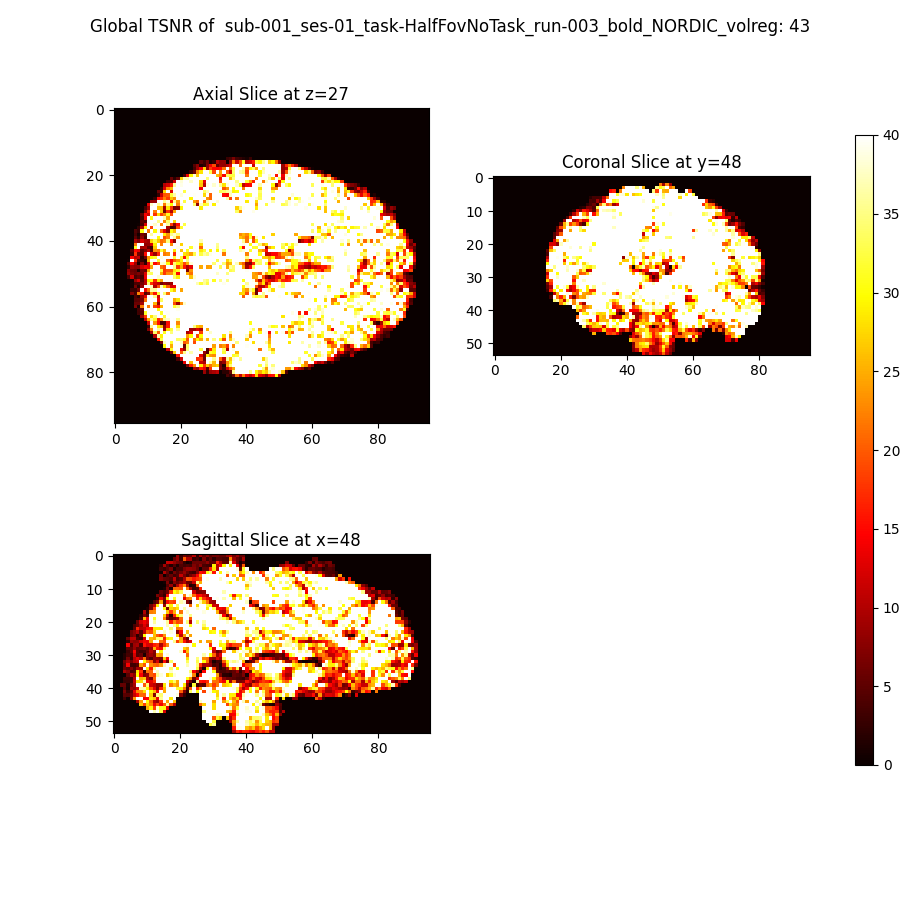

In [27]:
from IPython.display import Image
Image(filename=tsnr_img_nordic)

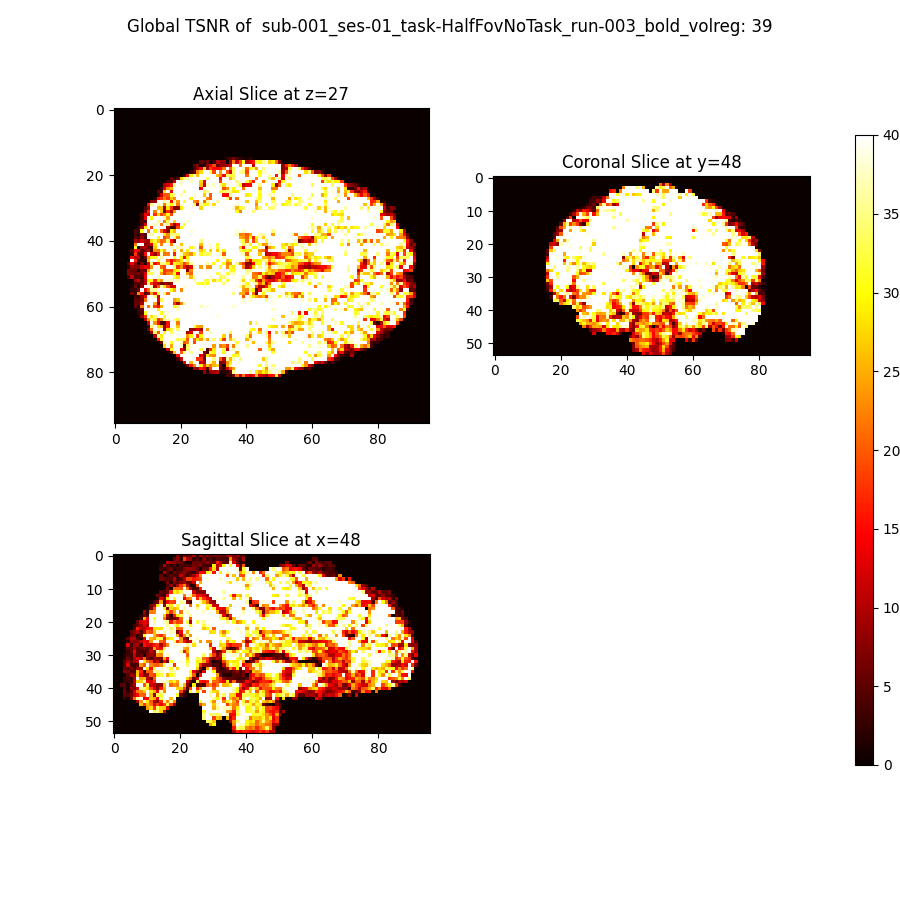

In [28]:
# Display a local image
Image(filename=tsnr_img_raw)